## Summarize the centriole compensation

Required input:

For the midline: a list of X_coordinate and a list of Y_coordinate

For the edge: a list of X_coordinate and a list of Y_coordinate

For the centriole: a list of list containing [X_coordinate, Y_coordinate, an angle (in degrees)]

In [1]:
import import_ipynb

from tools.Centriole_Characteristic import *
from tools.Extract_Experiment_Characteristic import *
from tools.CNN_Tools import *

importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Centriole_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\ToolBox.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Midline_Edge_Reformater.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\Extract_Experiment_Characteristic.ipynb
importing Jupyter notebook from C:\Users\Equipe_Azimzadeh\Desktop\Planarians\tools\CNN_Tools.ipynb


In [2]:
path = './data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm'

db = get_xls_values(path)

x_mid = db['worm_midline']['x']
y_mid = db['worm_midline']['y']
x_edg = db['worm_edge']['x']
y_edg = db['worm_edge']['y']

newY_mid, newY_edg = [], []
for y in y_mid:
    newY_mid.append(-y)
    
for y in y_edg:
    newY_edg.append(-y)

./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm


In [3]:
# From a midline and an edge, give as output
midline_final = aggregate_segment_char(x_mid, newY_mid, 
                                       x_edg, newY_edg, 
                                       n_midline_seg = 50, 
                                       n_sub_segment = 25, 
                                       n_edge_seg = 200)

In [4]:
import xlrd  

xls_name = "./data_excel_example/150518_Smed-Unc22_Rootletin_100x-1(V3-2c).xlsm"

with xlrd.open_workbook(xls_name) as xls_file:
    # Go to appropriate sheet (index 0)
    xls_sheet = xls_file.sheet_by_index(0)

a_list_of_centriole = []

pixel_size = db['image_pixel_size_in_um']
x_shift = db['image_shift']['x']
y_shift = db['image_shift']['y']
print(x_shift)
print(y_shift)

for row in range(xls_sheet.nrows - 7):
    if isinstance(xls_sheet.cell_value(row + 7, 3), (float, int)):
        X = xls_sheet.cell_value(row + 7, 3)/pixel_size + x_shift
        Y = -(xls_sheet.cell_value(row + 7, 4)/pixel_size + y_shift)
        angle = xls_sheet.cell_value(row + 7, 1)
        
        a_list_of_centriole.append(((X, Y), angle))

12445.0
7627.0


In [5]:
reoriented_centriole = []

for a_centriole in a_list_of_centriole:
    reoriented_centriole.append(centriole_characterizator(a_centriole, midline_final))
     

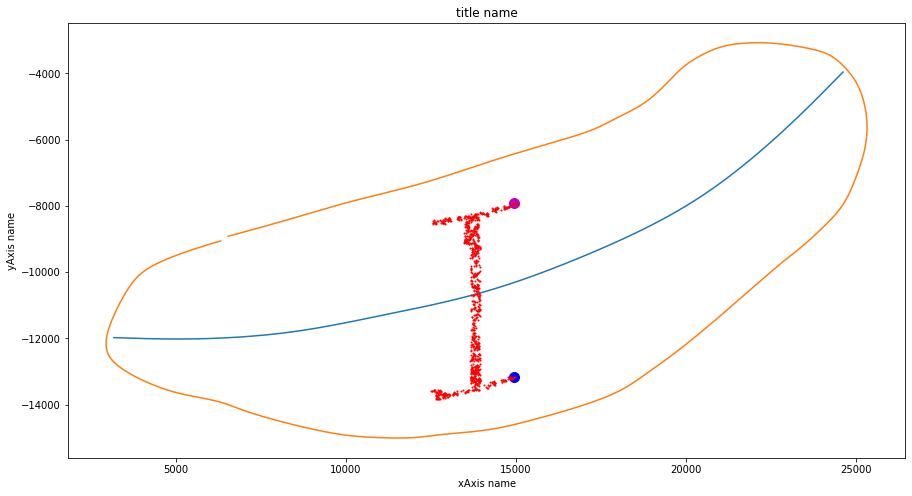

(23, 2726.177759135221, 11129.488960356099, 'right', 0.6648837709762406, 0.47008295479823, -8.573984290616457)
(27, 2259.6958878075616, 12818.219952531135, 'left', 0.6150422261712883, 0.5414109068262796, 6.67245875539958)


In [7]:
import matplotlib.pyplot as plt

i = 849
j = 850

plt.figure(figsize=(15,8))
plt.plot(x_mid, newY_mid)
plt.plot(x_edg, newY_edg)
plt.plot(a_list_of_centriole[i][0][0], a_list_of_centriole[i][0][1], 'bo', markersize = 10)
plt.plot(a_list_of_centriole[j][0][0], a_list_of_centriole[j][0][1], 'mo', markersize = 10)
for z in a_list_of_centriole:
    plt.plot(z[0][0], z[0][1], 'ro', markersize = 1)

plt.title('title name')
plt.xlabel('xAxis name')
plt.ylabel('yAxis name')
plt.show()

print(reoriented_centriole[i])
print(reoriented_centriole[j])

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [35]:
for i in range(1 , 10 , 2):
    print(i, i/10, (i/10)//-0.2)
    
for i in range(1 , 10 , 2):
    print(-i, (-i/10), (-i/10)//0.2)

1 0.1 -1.0
3 0.3 -2.0
5 0.5 -3.0
7 0.7 -4.0
9 0.9 -5.0
-1 -0.1 -1.0
-3 -0.3 -2.0
-5 -0.5 -3.0
-7 -0.7 -4.0
-9 -0.9 -5.0


In [50]:
a_dict = {}

for ele in reoriented_centriole:
    if ele[3] == 'right':
        lat = -ele[4] + 1
    else:
        lat = ele[4] + 1
    
    lat_ = int(lat//0.2)
    long = int(ele[5] // 0.2)
    
    a_dict[long][lat] += 1
    
        

KeyError: 2

In [54]:
test = 10

a_dict[test] += 1

KeyError: 10

In [52]:
a_dict

{}